# 0. Import libraries and load DataFrame

In [1]:
!pip install pandas -q
!pip install numpy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q
!pip install scipy -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import math
import seaborn as sns

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
poi_df = pd.read_csv('data/poi.csv')

/tmp/ipykernel_15719/4245473066.py:3: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df = pd.read_csv('data/poi.csv')


# 1. Data Preparing

# 1.1. Point of Interest Analysis

In [4]:
poi_df = poi_df[['lat', 'lon']]

In [5]:
poi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397382 entries, 0 to 397381
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   lat     397382 non-null  float64
 1   lon     397382 non-null  float64
dtypes: float64(2)
memory usage: 6.1 MB


In [6]:
poi_df.describe()

,lat,lon
count,397382.000000,397382.000000
mean,44.626623,9.892288
std,1.688876,2.177054
min,41.796301,6.079171
25%,41.936513,9.146079
50%,45.466917,9.218977
75%,45.514360,12.446640
max,46.247779,12.626012


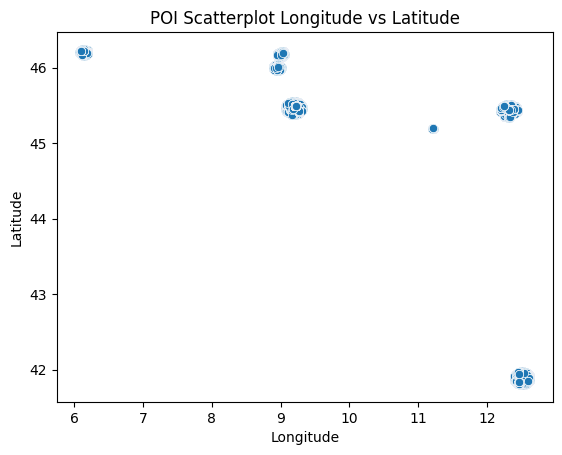

In [7]:
sns.scatterplot(x='lon', y='lat', data=poi_df)
plt.title('POI Scatterplot Longitude vs Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

# 1.2. Train Dataset Analysis

In [8]:
# drop id
train_df.drop('id', axis=1, inplace=True)

# 1.3. Add Features

In [9]:
def get_n_poi(lat, lon, poi_df, radius=0.001):
    if math.isnan(lat) or math.isnan(lon):
        return np.nan
    # radius = 0.03 -> 3km
    # get all poi in a certain radius from the current lat and lon
    series = poi_df[(poi_df['lat']-lat)**2 + (poi_df['lon']-lon)**2 <= radius**2]
    # n_poi = np.nan if series.shape[0] == 0 else series.shape[0]
    return series.shape[0] # n_poi

In [10]:
train_df['n_poi'] = train_df.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)

In [11]:
def lambda_ratio(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    if not math.isnan(n_room) and not math.isnan(n_bathroom):
        return n_room/max(1, n_bathroom) 
    else:
        return np.nan

In [12]:
train_df['ratio'] = train_df.apply(lambda x: lambda_ratio(x), axis=1)

In [13]:
def lambda_m2_per_bathrooms(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    m2 = x['surface']
    if not math.isnan(n_bathroom) and not math.isnan(m2):
        return m2/max(1, n_room*3 + n_bathroom)
    else:
        return np.nan

In [14]:
train_df['m2_per_bathrooms'] = train_df.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)

# 1.4. Fill NaNs

In [15]:
train_df['garden'] = train_df['garden'].fillna(False)
train_df['balcony'] = train_df['balcony'].fillna(False)

In [16]:
train_df['garden'] = train_df['garden'].apply(lambda x: 1 if x == True else 0)
train_df['balcony'] = train_df['balcony'].apply(lambda x: 1 if x == True else 0)

In [17]:
map_conditions = {}
index = 0
for value in train_df['conditions'].unique():
    if value not in map_conditions:
        map_conditions[value] = index
        index += 1
map_conditions

{'Buono stato / Abitabile': 0,
 'Ottimo / Ristrutturato': 1,
 'Da ristrutturare': 2,
 'Nuovo / Nuova costruzione': 3,
 nan: 4}

In [18]:
train_df['conditions'] = train_df['conditions'].apply(lambda x: map_conditions[x])
train_df['conditions'] = train_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)

# 2. Data Processing

# 2.1. Data Transformation

In [19]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [20]:
# StandardScaler
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
x_train = pd.DataFrame(x_scaler.fit_transform(x_train), columns=x_train.columns)
y_scaler = StandardScaler()
y_train = pd.DataFrame(y_scaler.fit_transform(y_train.values.reshape(-1, 1)), columns=['price'])

In [21]:
from sklearn.impute import KNNImputer
x_imputer = KNNImputer()
x_train = pd.DataFrame(x_imputer.fit_transform(x_train), columns=x_train.columns)

In [22]:
from sklearn.preprocessing import Normalizer
x_normalizer = Normalizer()
x_train = pd.DataFrame(x_normalizer.fit_transform(x_train), columns=x_train.columns)

# 2.2.

In [23]:
train_df = pd.concat([x_train, y_train], axis=1)

In [24]:
original_shape = train_df.shape[0]
z_scores = zscore(train_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 5).all(axis=1)

In [26]:
train_df = train_df[filtered_entries]
new_shape = train_df.shape[0]

In [27]:
print('original shape: {}'.format(original_shape))
print('new shape: {}'.format(new_shape))
print('percentage of rows removed: {}%'.format(((original_shape-new_shape)*100)/original_shape))

original shape: 46312
new shape: 38940
percentage of rows removed: 15.918120573501469%


# 2.3.

In [28]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [29]:
from sklearn.ensemble import RandomForestRegressor

# compute feature_importances
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
sorted(rf.feature_importances_, reverse=True)

[0.43660867614668336,
 0.12230150974134162,
 0.07728530191767496,
 0.05366791511863683,
 0.05105418340840759,
 0.02950306478060222,
 0.02662001215458628,
 0.025075237041565362,
 0.023862740049568957,
 0.02205630751164491,
 0.021810869408437482,
 0.02110463338635871,
 0.020410748672596755,
 0.016609922640835367,
 0.015044906322553103,
 0.014487287537524603,
 0.012313789840252349,
 0.01018289432072949]

<BarContainer object of 18 artists>

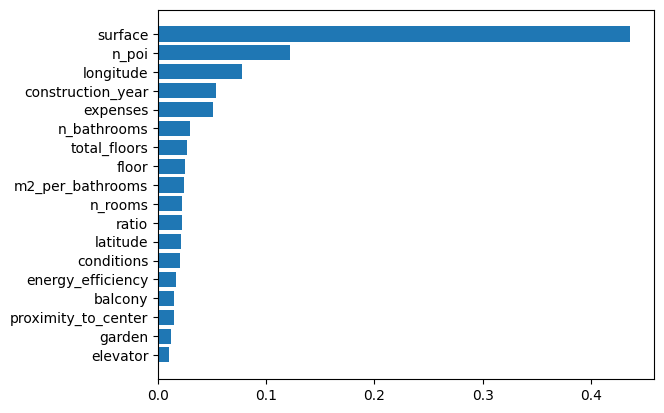

In [30]:
# plot feature_importances
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])

# 4. Training

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'MLPRegressor': MLPRegressor(),
    'SVR': SVR()
}

In [32]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    model.fit(x_train, y_train)

model: RandomForestRegressor


# 5. Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score
def evaluate_model(model, x, y, y_scaler, scoring='neg_mean_squared_error'):
    scores = cross_val_score(model, x, y, cv=5, scoring=scoring)
    print('scores: {}'.format(scores))
    print('mean: {}'.format(scores.mean()))
    print('std: {}'.format(scores.std()))
    # plot scatter plot of y_pred vs y_true
    y_pred = y_scaler.inverse_transform(model.predict(x).reshape(-1, 1))
    y = y_scaler.inverse_transform(y.values.reshape(-1, 1))
    plt.scatter(y, y_pred)
    plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())], 'r--', lw=2)
    plt.title('{}'.format(model))
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.show()
    plt.close()
    return scores

In [ ]:
performance = {model_name: {'MSE_mean': 0.0, 'MSE_std': 0.0} for model_name in models.keys()}

In [ ]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    MSE_scores = evaluate_model(model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
    performance[model_name]['MSE_mean'] = -MSE_scores.mean()
    performance[model_name]['MSE_std'] = MSE_scores.std()

In [ ]:
performance_df = pd.DataFrame.from_dict(performance, orient='index').sort_values(by='MSE_mean').reset_index().rename(columns={'index': 'model'})
performance_df

# 6. Submission

In [33]:
def x_test_preprocessing(x_test, map_conditions, x_scaler, x_imputer, x_normalizer):
    x_test['n_poi'] = x_test.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)
    x_test['ratio'] = x_test.apply(lambda x: lambda_ratio(x), axis=1)
    x_test['m2_per_bathrooms'] = x_test.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)
    x_test['garden'] = x_test['garden'].fillna(False)
    x_test['balcony'] = x_test['balcony'].fillna(False)
    x_test['garden'] = x_test['garden'].apply(lambda x: 1 if x == True else 0)
    x_test['balcony'] = x_test['balcony'].apply(lambda x: 1 if x == True else 0)
    x_test['conditions'] = x_test['conditions'].apply(lambda x: map_conditions[x])
    x_test['conditions'] = x_test['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)
    x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(x_imputer.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(x_normalizer.transform(x_test), columns=x_test.columns)
    return x_test

In [34]:
test_id = test_df['id']
x_test = test_df.drop('id', axis=1)
x_test = x_test_preprocessing(x_test, map_conditions, x_scaler, x_imputer, x_normalizer)

In [35]:
def submission(model, filename, x_test, y_scaler):
    y_pred = y_scaler.inverse_transform(model.predict(x_test).reshape(-1, 1))
    y_pred = pd.DataFrame(y_pred, columns=['price'])
    submission_df = pd.concat([test_id, y_pred], axis=1)
    submission_df.to_csv(filename, index=False)
    return

In [36]:
for model_name, model in models.items():
    submission(model, 'submission/{}.csv'.format(model_name), x_test, y_scaler)

# 7. Tuning

- troviamo la combinazione di iperparametri migliori per il modello migliore che abbiamo fino ad ora ottenuto
- quindi accordiamo il modello migliore

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 15],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

In [ ]:
best_params = grid_search.best_params_
best_params

In [ ]:
tuned_model = RandomForestRegressor(**best_params)
tuned_model.fit(x_train, y_train)
MSE_score = evaluate_model(tuned_model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
print('MSE: {:.3f} ({:.3f} std)'.format(-MSE_score.mean(), MSE_score.std()))

In [ ]:
submission(tuned_model, 'submission/tuned_model.csv', x_test, y_scaler)